In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc3 as pm ## If this line gives you an error, uncomment and execute the following cell

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# !pip install pymc3

# We can (optionally) specify the random seed for our random number generators

In [3]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

# Load the dataset stored in a CSV (comma separated value) file
We use the Python package called Pandas to read the data from a CSV file and as a data structure to work with the data. The data structure is called a Data Frame.

In [4]:
data_all = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
data_all

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


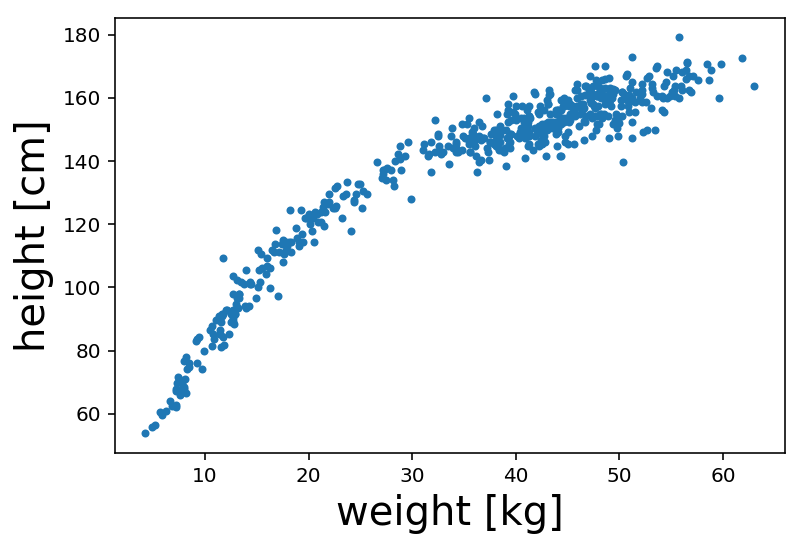

In [35]:
figure(1, [6, 4])
plot(data_all['weight'], data_all['height'], '.')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);

## We want to filter for only those over age 18

In [6]:
data_adult = data_all[data_all['age'] >= 18] ## this is logical indexing (it also works for arrays)
data_adult

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0


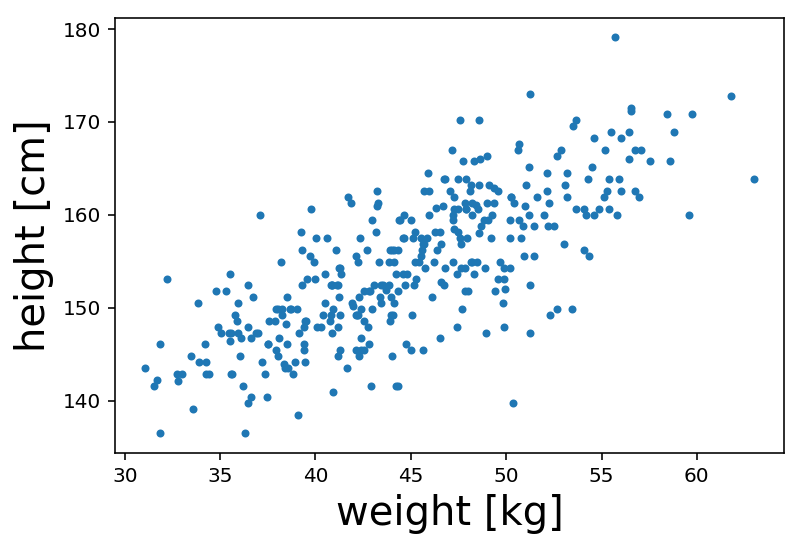

In [34]:
figure(1, [6, 4])
plot(data_adult['weight'], data_adult['height'], '.')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);

# Generative model
\begin{align*}
    h_{i} &\sim \text{Normal}(\mu_{i}, \sigma) \\
    \mu_{i} &= \alpha + \beta(x_{i} - \bar{x}) \\
    \alpha &\sim \text{Normal}(178, 20) \\
    \beta & \sim \text{Normal}(0, 10) \\
    \sigma &\sim \text{Uniform}(0, 50)
  \end{align*}

## Let's check our prior to see if it makes sense

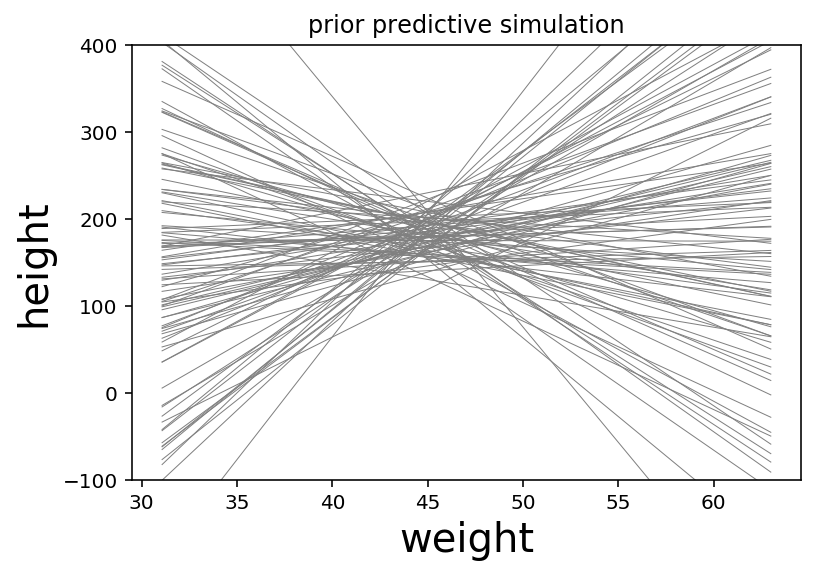

In [43]:
n_samples = 100  # 100 lines
alpha = stats.norm.rvs(178, 20, n_samples)
beta = stats.norm.rvs(0, 10, n_samples)

xmin = data_adult['weight'].min()
xmax = data_adult['weight'].max()
xmean = data_adult['weight'].mean()
x = linspace(xmin, xmax, 5) ## weight range

## we are using broadcasting here (see Notebook in Week 4)
h_avg = alpha[None, :] + beta[None, :]*(x[:, None] - xmean) 

plot(x, h_avg, '0.5', lw=0.5)
ylim(-100, 400)
title('prior predictive simulation')
xlabel('weight', fontsize=20)
ylabel('height', fontsize=20);

## As suggested in the book, let us try a different prior for $\beta$

$$ \log(\beta) \sim \text{Normal}(0, 1) $$
or more usefully
$$ \beta \sim \text{Lognormal(0, 1)}$$


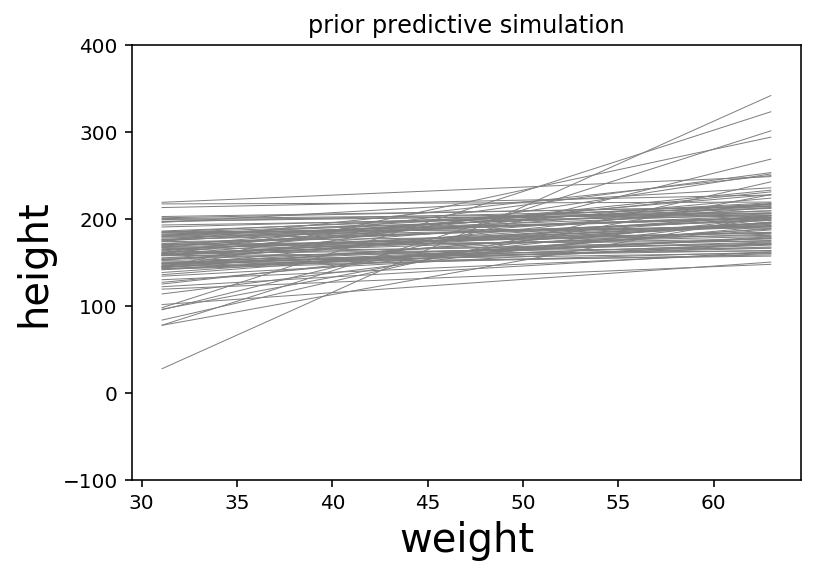

In [42]:
n_samples = 100  # 100 lines
alpha = stats.norm.rvs(178, 20, n_samples)
logbeta = stats.norm.rvs(0, 1, n_samples)

xmin = data_adult['weight'].min()
xmax = data_adult['weight'].max()
xmean = data_adult['weight'].mean()
x = linspace(xmin, xmax, 5) ## weight range
h_avg = alpha[None, :] + exp(logbeta[None, :])*(x[:, None] - xmean) ## we are using broadcasting here

plot(x, h_avg, '0.5', lw=0.5)
ylim(-100, 400)
title('prior predictive simulation')
xlabel('weight', fontsize=20)
ylabel('height', fontsize=20);

# Use the MCMC sampling tools in the PyMC3 package to approximate the posterior distribution
\begin{align*}
    h_{i} &\sim \text{Normal}(\mu_{i}, \sigma) \\
    \mu_{i} &= \alpha + e^{log(\beta)}(x_{i} - \bar{x}) \\
    \alpha &\sim \text{Normal}(178, 20) \\
    \log(\beta) & \sim \text{Normal}(0, 1) \\
    \sigma &\sim \text{Uniform}(0, 50)
  \end{align*}

In [10]:
with pm.Model() as model_4_3:
    sigma = pm.Uniform("sigma", 0, 50)
    alpha = pm.Normal("alpha", mu=178, sd=20)
    logbeta = pm.Normal("logbeta", mu=0, sd=1)
    mu = alpha + exp(logbeta)*(data_adult['weight'] - data_adult['weight'].mean())
    height = pm.Normal("height", mu=mu, sd=sigma, observed=data_adult['height'])
    trace_4_3 = pm.sample(1000, tune=1000) ## these are the MCMC samples!

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  import sys
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logbeta, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


## Convert the posterior sample output into a DataFrame
## Most of the rest of the notebook will use these MCMC samples!

In [11]:
trace_4_3_df = pm.trace_to_dataframe(trace_4_3)
trace_4_3_df

,alpha,logbeta,sigma
0,154.508982,-0.102237,4.838443
1,154.570485,-0.109457,5.381978
2,155.046194,-0.069461,5.031198
3,154.749885,-0.073164,5.320762
4,154.749885,-0.073164,5.320762
...,...,...,...
3995,155.137081,-0.045603,5.347500
3996,154.109069,-0.166729,4.853440
3997,154.836679,-0.071856,5.251133
3998,154.322411,-0.159326,5.004493


# What is the posterior probability of the average height $\mu$ of someone whos weight is $50$kg
$$ p(\mu | w=50{\rm kg}, \text{data})$$

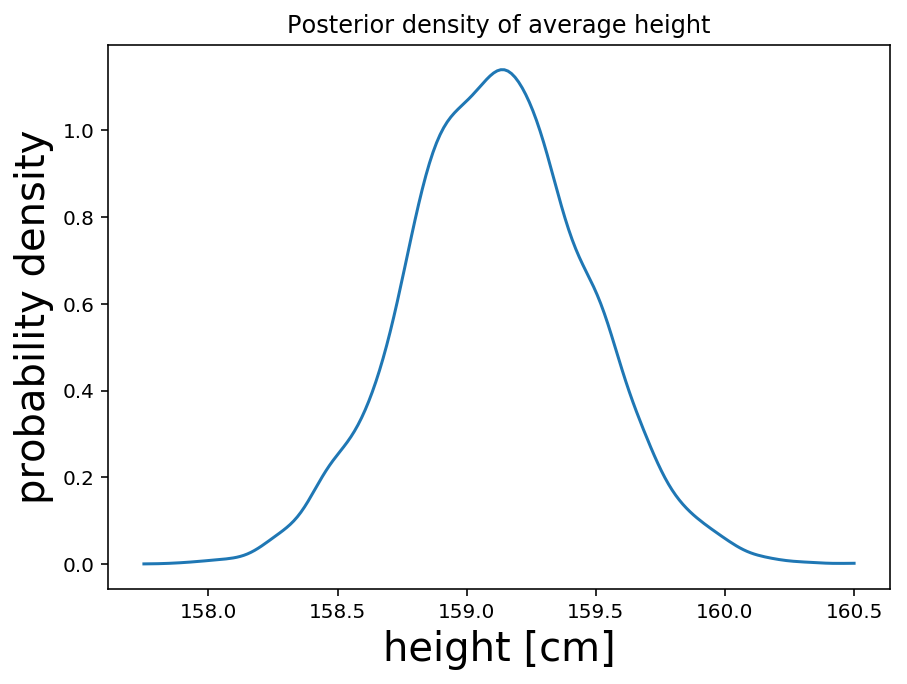

In [33]:
alpha_samples = array(trace_4_3_df['alpha'])
logbeta_samples = array(trace_4_3_df['logbeta'])
h_avg_samples = alpha_samples + exp(logbeta_samples)*(50 - data_adult['weight'].mean())

## using code from Week 3 notebook
kde_posterior_pdf = stats.gaussian_kde(h_avg_samples)
figure(1, [7, 5])
x_to_plot = linspace(157.75, 160.5, 200)
plot(x_to_plot, kde_posterior_pdf(x_to_plot))
title('Posterior density of average height')
xlabel('height [cm]', fontsize=20)
ylabel('probability density', fontsize=20);

## What about the posterior for the height $h$ (instead of the average height $\mu$)?
$$ p(h | w=50{\rm kg}, \text{data})$$

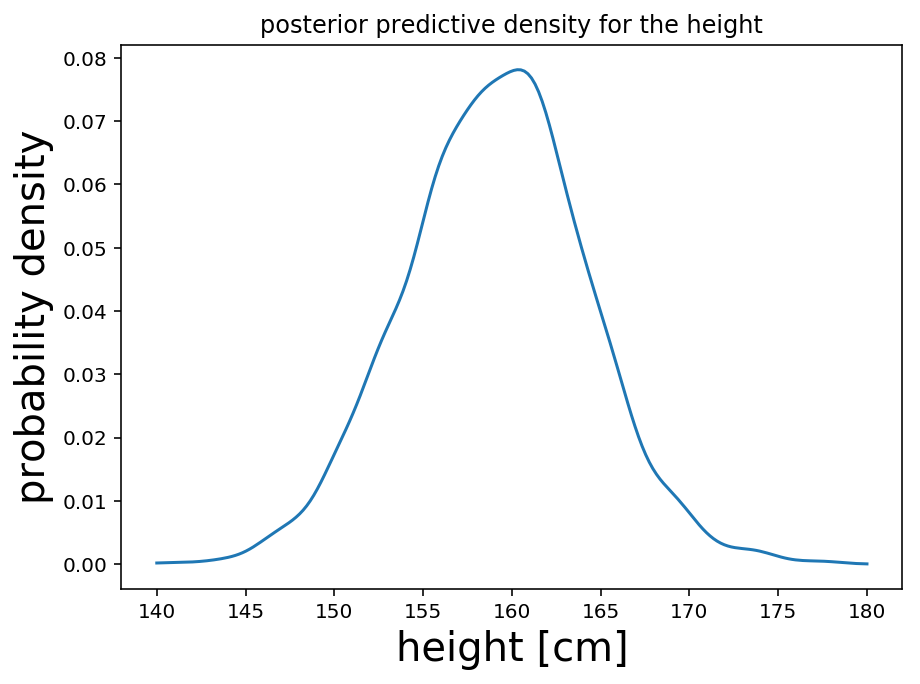

In [32]:
alpha_samples = array(trace_4_3_df['alpha'])
logbeta_samples = array(trace_4_3_df['logbeta'])
mu_samples = alpha_samples + exp(logbeta_samples)*(50 - data_adult['weight'].mean())
sigma_samples = array(trace_4_3_df['sigma'])


h_samples = stats.norm.rvs(
    mu_samples, 
    sigma_samples, 
    size=sigma_samples.size)

## using code from Week 3 notebook
kde_posterior_pred_pdf = stats.gaussian_kde(h_samples)
figure(1, [7, 5])
# x_to_plot = linspace(157.75, 160.5, 200)
# plot(x_to_plot, kde_posterior_pdf(x_to_plot), label='Posterior pdf of avg height')
x_to_plot = linspace(140, 180, 200)
plot(x_to_plot, kde_posterior_pred_pdf(x_to_plot), label='Posterior pdf of height')
title('posterior predictive density for the height')
xlabel('height [cm]', fontsize=20)
ylabel('probability density', fontsize=20);

# Graphing the posterior distribution of average height $\mu$

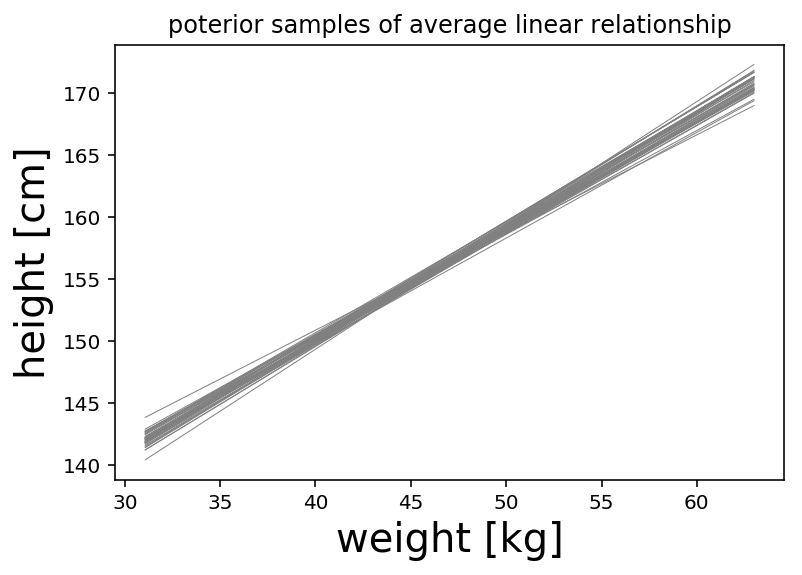

In [41]:
xmin = data_adult['weight'].min()
xmax = data_adult['weight'].max()
xmean = data_adult['weight'].mean()
x = linspace(xmin, xmax, 5) ## weight range
alpha_samples = array(trace_4_3_df['alpha'])[None, ::100] # every 100th data point
logbeta_samples = array(trace_4_3_df['logbeta'])[None, ::100] # every 100th data point
h_avg = alpha_samples + exp(logbeta_samples)*(x[:, None] - xmean)

plot(x, h_avg, '0.5', lw=0.5)
title('poterior samples of average linear relationship')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);

## A different way of looking at the posterior distribution for the average height $\mu$

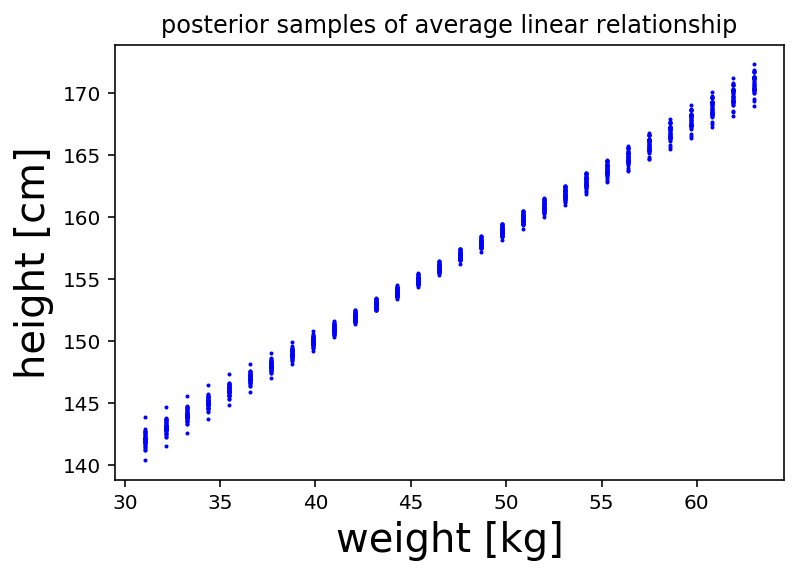

In [44]:
xmin = data_adult['weight'].min()
xmax = data_adult['weight'].max()
xmean = data_adult['weight'].mean()
x = linspace(xmin, xmax, 30) ## weight range
alpha_samples = array(trace_4_3_df['alpha'])[None, ::100] ## every 100th data point
logbeta_samples = array(trace_4_3_df['logbeta'])[None, ::100] ## every 100th data point
mu_samples = alpha_samples + exp(logbeta_samples)*(x[:, None] - xmean)

plot(x, mu_samples, 'b.', ms=2)
title('posterior samples of average linear relationship')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);

## Graphing credible intervals of the posterior for average height $\mu$
The shaded region shows the 89% credible intervals of the average height, for each weight

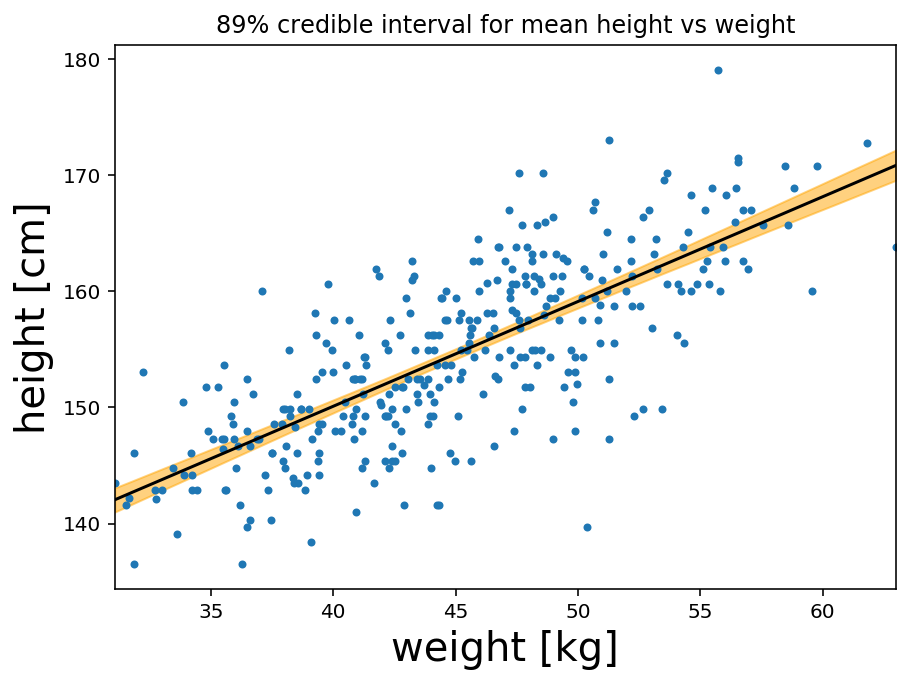

In [45]:
prob = 0.89 ## for credible intervals

xmin = data_adult['weight'].min()
xmax = data_adult['weight'].max()
xmean = data_adult['weight'].mean()
x = linspace(xmin, xmax, 50) ## weight range
alpha_samples = array(trace_4_3_df['alpha'])[None, :] 
logbeta_samples = array(trace_4_3_df['logbeta'])[None, :] 
N_posterior_samples = alpha_samples.size

mu_samples = alpha_samples + exp(logbeta_samples)*(x[:, None] - xmean)
## lower bound and upper bound for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

## the posterior mean
mu_avg = alpha_samples.mean() + exp(logbeta_samples).mean()*(x - xmean)


figure(1, [7, 5])
plot(data_adult['weight'], data_adult['height'], '.')
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('89% credible interval for mean height vs weight')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);

# Let us add in the prediction intervals
## we want to look at variability in height and average height

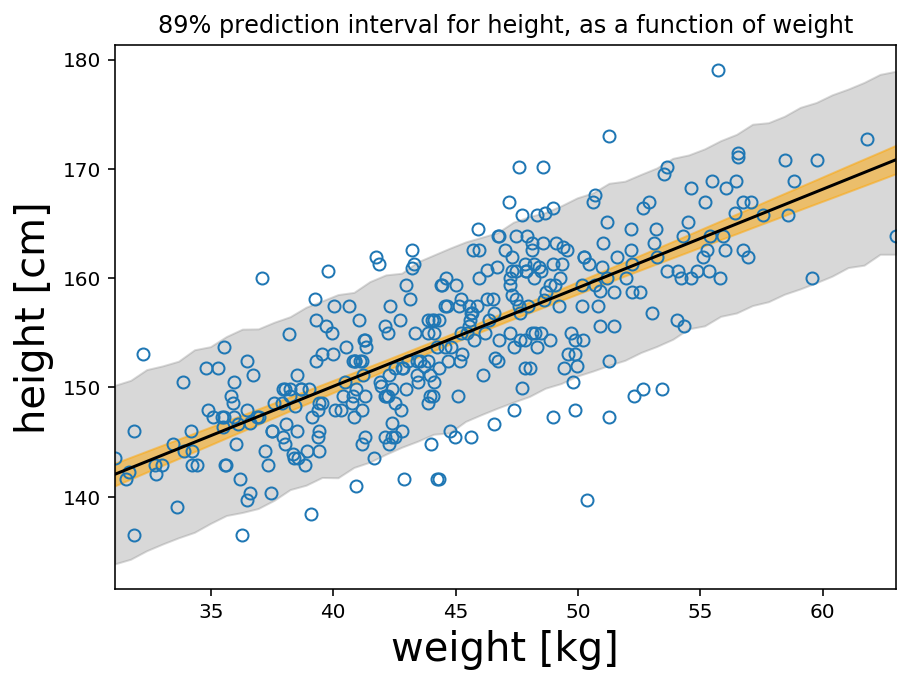

In [46]:
prob = 0.89 ## for credible intervals

xmin = data_adult['weight'].min()
xmax = data_adult['weight'].max()
xmean = data_adult['weight'].mean()

N_weight = 50
x = linspace(xmin, xmax, N_weight) ## weight range

alpha_samples = array(trace_4_3_df['alpha'])[None, :] 
logbeta_samples = array(trace_4_3_df['logbeta'])[None, :] 
sigma_samples = array(trace_4_3_df['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = alpha_samples.mean() + exp(logbeta_samples).mean()*(x - xmean)

#### collect samples of the average height
mu_samples = alpha_samples + exp(logbeta_samples)*(x[:, None] - xmean)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples, 
    sigma_samples, 
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [7, 5])

fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(data_adult['weight'], data_adult['height'], 'o', mfc='none')
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('89% prediction interval for height, as a function of weight')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);

# There is no reason we have to use a linear function for regression!
## Let us try fitting a cubic function to the full height vs weight dataset
For stability, we first 'standardize' the predictor variable (weight) so that $x_s$ has mean zero and unit standard deviation, 
$$ x_s = \frac{x_{i} - \bar{x}}{\text{std}(x_{i} - \bar{x})} .$$
Our cubic model is
\begin{align*}
    h_{i} &\sim \text{Normal}(\mu_{i}, \sigma) \\
    \mu_{i} &= \alpha + e^{\log(\beta_1)}x_s + \beta_2 x_s^2 + \beta_3 x_s^3 \\
    \alpha &\sim \text{Normal}(178, 20) \\
    \log(\beta_1) & \sim \text{Normal}(0, 1) \\
    \beta_2 & \sim \text{Normal}(0, 1) \\
    \beta_3 & \sim \text{Normal}(0, 1) \\
    \sigma &\sim \text{Uniform}(0, 50)
\end{align*}

In [18]:
x_shifted = array(data_all['weight'] - data_all['weight'].mean())
x_standardized = x_shifted/x_shifted.std()
with pm.Model() as model_cubic:
    alpha = pm.Normal("alpha", mu=178, sd=20)
    logbeta1 = pm.Normal("logbeta1", mu=0, sd=1)
    beta2 = pm.Normal("beta2", mu=0, sd=1)
    beta3 = pm.Normal("beta3", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = alpha + exp(logbeta1)*x_standardized + beta2*x_standardized**2 + beta3*x_standardized**3
    height = pm.Normal("height", mu=mu, sd=sigma, observed=data_all['height'])
    trace_cubic = pm.sample(1000, tune=1000) ## these are the MCMC samples!
trace_cubic = pm.trace_to_dataframe(trace_cubic)
trace_cubic

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta3, beta2, logbeta1, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


,alpha,logbeta1,beta2,beta3,sigma
0,146.485113,2.718605,-5.935892,3.791244,4.756309
1,145.993111,2.707068,-6.204883,3.532212,4.802823
2,146.612388,2.736500,-5.994159,3.503757,4.784793
3,146.313033,2.745899,-5.941350,3.389606,4.975833
4,146.603755,2.667493,-6.457098,3.778525,4.703440
...,...,...,...,...,...
3995,146.357398,2.728529,-6.066730,3.530276,4.724998
3996,146.493517,2.677011,-6.031143,3.936389,4.920380
3997,146.394576,2.675845,-6.144242,3.824798,4.899053
3998,146.317129,2.696127,-6.256078,3.683695,4.662022


## Check our priors

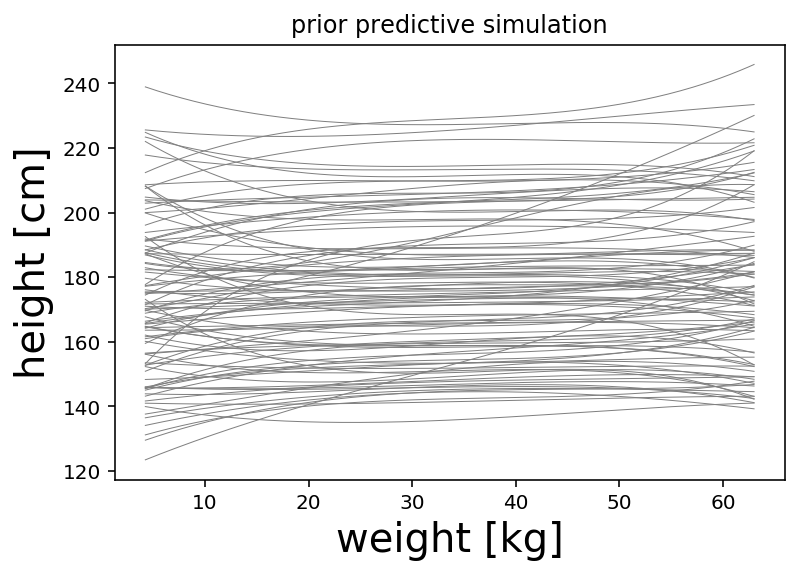

In [50]:
n_samples = 100

alpha = stats.norm.rvs(178, 20, n_samples)
logbeta1 = stats.norm.rvs(0, 1, n_samples)
beta2 = stats.norm.rvs(0, 1, n_samples)
beta3 = stats.norm.rvs(0, 1, n_samples)

xmin = data_all['weight'].min()
xmax = data_all['weight'].max()
xmean = data_all['weight'].mean()
x = linspace(xmin, xmax, 200) ## weight range
xsmin = x_standardized.min()
xsmax = x_standardized.max()
x_s = linspace(xsmin, xsmax, 200) ## standardized weight range

mu = (alpha[None, :] 
      + exp(logbeta1[None, :])*x_s[:, None]
      + beta2[None, :]*x_s[:, None]**2 
      + beta3[None, :]*x_s[:, None]**3)

plot(x, mu, '0.5', lw=0.5)
# ylim(-100, 400)
title('prior predictive simulation')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);

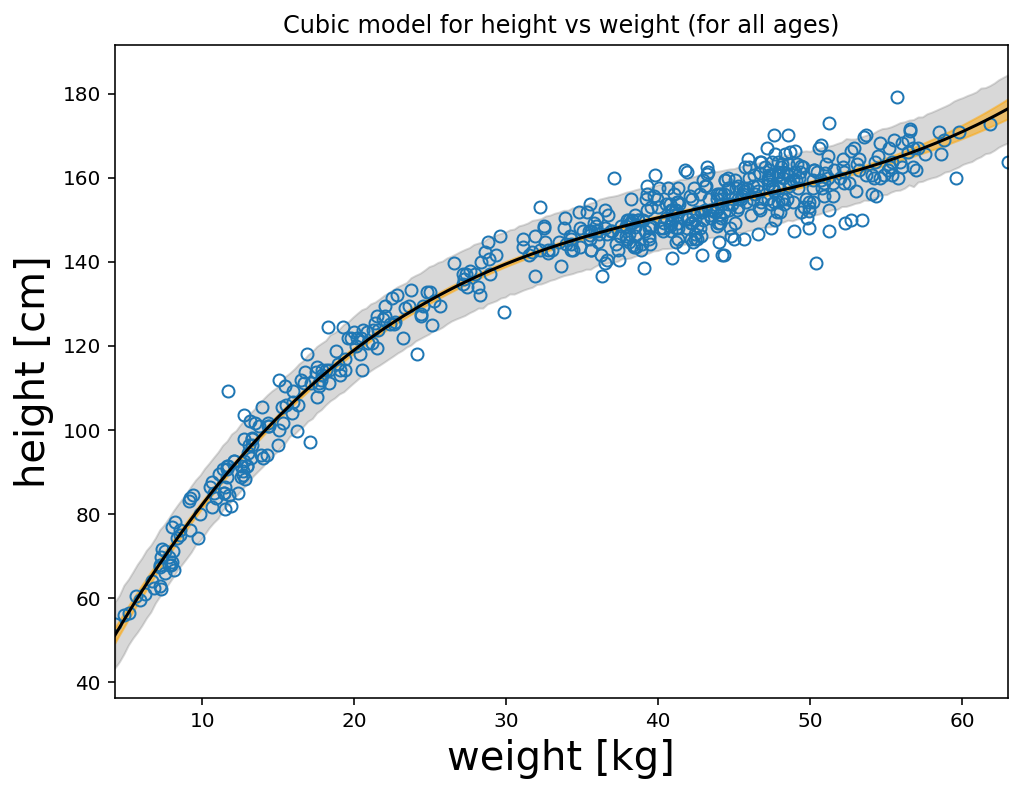

In [54]:
prob = 0.89 ## for credible intervals

N_weight = 200
xmin = data_all['weight'].min()
xmax = data_all['weight'].max()
xmean = data_all['weight'].mean()
x = linspace(xmin, xmax, N_weight) ## weight range
xsmin = x_standardized.min()
xsmax = x_standardized.max()
x_s = linspace(xsmin, xsmax, N_weight)[:, None] ## standardized weight range

alpha_samples = array(trace_cubic['alpha'])[None, :] 
logbeta1_samples = array(trace_cubic['logbeta1'])[None, :] 
beta2_samples = array(trace_cubic['beta2'])[None, :] 
beta3_samples = array(trace_cubic['beta3'])[None, :] 
sigma_samples = array(trace_cubic['sigma'])[None, :]
N_posterior_samples = alpha_samples.size

#### the mean posterior average height
mu_avg = (alpha_samples.mean() 
          + exp(logbeta1_samples).mean()*x_s
          + beta2_samples.mean()*x_s**2
          + beta3_samples.mean()*x_s**3)
#### collect samples of the average height
mu_samples = (alpha_samples 
              + exp(logbeta1_samples)*x_s
              + beta2_samples*x_s**2
              + beta3_samples*x_s**3)
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
mu_samples_sorted = sort(mu_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]

#### Sample the posterior prediction height
h_samples = stats.norm.rvs(
    mu_samples, 
    sigma_samples, 
    size=(N_weight, N_posterior_samples))
## lower bound and upper credible inteval bounds for each fixed weight in the array `x`
h_samples_sorted = sort(h_samples, axis=1)
index = int(N_posterior_samples*(1 - prob)/2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]


##### Figure code

figure(1, [8, 6])
plot(data_all['weight'], data_all['height'], 'o', mfc='none')
fill_between(x, h_upper, h_lower, color='0.5', alpha=0.3)
fill_between(x, mu_upper, mu_lower, color='orange', alpha=0.5)
plot(x, mu_avg, 'k')

xlim(xmin, xmax)
title('Cubic model for height vs weight (for all ages)')
xlabel('weight [kg]', fontsize=20)
ylabel('height [cm]', fontsize=20);